In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('../peptidome.mplstyle')

import sys
sys.path.append('..')
from lib import *

%load_ext autoreload

In [2]:
df = load_unirefproteome_as_df_path(datadir + 'human-viruses-uniref90.fasta')
df['length'] = df['Sequence'].str.len()
df.sort_values('length', ascending=False, inplace=True)
df = df[~df['header'].str.contains('(Fragment)')]

/home/amayer/anaconda3/envs/py3/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [3]:
df['TaxID_species'] = df['TaxID'].apply(normalize_taxid)

11118 7
290028 is species
694003 is species
2697049 12
2509481 10
11137 is species
277944 is species
1980521 is species
1980519 is species
10310 is species
11051 7
11079 is species
11082 is species
11072 is species
64315 9
59563 is species
64320 is species
11083 is species
44024 is species
11089 is species
164416 is species
38837 is species
12637 is species
10325 is species
340907 is species
10376 is species
10298 is species
10294 8
11103 is species
11108 11
10335 is species
37296 is species
11034 is species
2169701 is species
11036 is species
11019 7
11029 is species
37124 is species
1554474 10
59300 is species
59301 is species
194960 7
11033 is species
11020 is species
688449 7
11269 is species
12103 7
12104 9
204711 9
95341 7
11572 8
1979160 is species
39744 9
11158 7
121791 is species
63330 is species
10359 is species
11620 is species
138950 is species
12059 7
186539 is species
2169992 is species
186538 is species
2169991 is species
11623 is species
186540 is species
11628 is speci

In [4]:
def parse_protein_name(header):
    m = re.search('(?<=\s).+(?=\sn\=)', header)
    if m:
         return m.group(0)
    return ''

In [5]:
df['Protein name'] = df.apply(lambda row: parse_protein_name(row['header']), axis=1)

In [6]:
df['TaxID_species'].value_counts().head(20)

11676     40480
           2139
10407      2038
10310       895
10298       812
10359       787
11709       381
337041      352
11082       302
10243       284
10258       275
12475       257
10279       218
10376       206
10255       142
10245       141
37296       140
10325       131
99000       117
38804       106
Name: TaxID_species, dtype: int64

In [7]:
df = df[~(df['TaxID_species']=='')]

In [8]:
len(set(df['TaxID'].unique())), len(set(df['TaxID_species'].unique()))

(377, 173)

(array([45., 53., 35., 14., 13.,  8.,  3.,  1.,  0.,  1.]),
 array([0.        , 0.46072405, 0.9214481 , 1.38217215, 1.8428962 ,
        2.30362025, 2.7643443 , 3.22506835, 3.6857924 , 4.14651645,
        4.6072405 ]),
 <BarContainer object of 10 artists>)

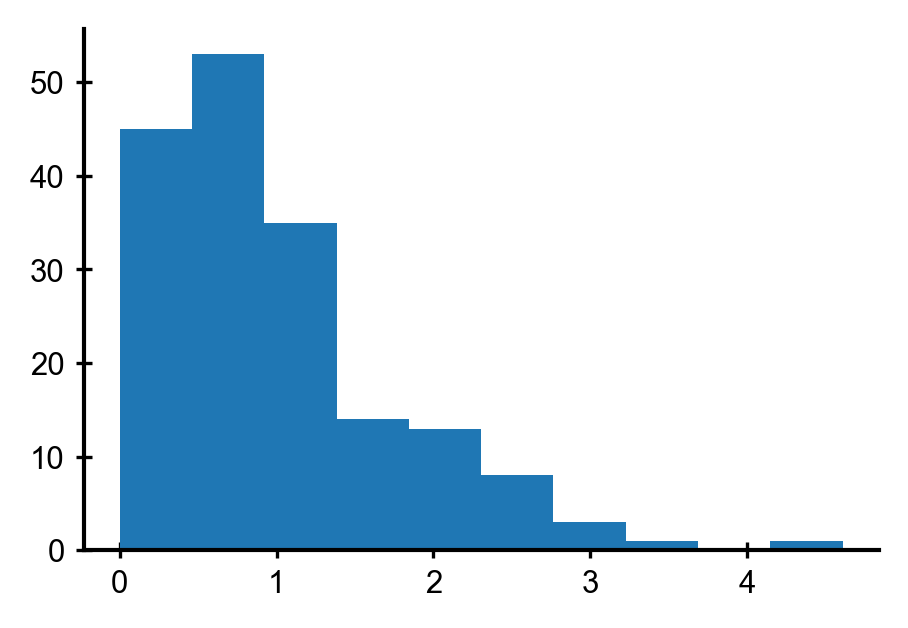

In [9]:
plt.hist(np.log10(df['TaxID_species'].value_counts()))

In [10]:
def counter_to_series(counter):
    count_df = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
    count_series = count_df.T.squeeze()
    return count_series
def fraction_multiple(series):
    return np.sum(series[series>1])/np.sum(series)

In [11]:
k = 9
filterlength = 12

In [12]:
count_series = counter_to_series(count_kmers_iterable(df['Sequence'], k, clean=True))
fraction_multiple(count_series)

0.8895016414165472

In [13]:
filtered = df.groupby(['TaxID_species', 'Protein name']).head(1)

In [14]:
def to_kmers_nonoverlapping(seqs, k):
    for seq in seqs:
        for i in range((len(seq)-k+1)//k):
            s = seq[k*i:k*(i+1)]
            if isvalidaa(s):
                yield s

In [15]:
df = load_unirefproteome_as_df_path(datadir + 'human-viruses-uniref90.fasta')
df['length'] = df['Sequence'].str.len()
df['TaxID_species'] = df['TaxID'].apply(normalize_taxid)
df = df[~(df['TaxID_species']=='')]
df['Protein name'] = df.apply(lambda row: parse_protein_name(row['header']), axis=1)
df = df[~df['header'].str.contains('(Fragment)')]
df = df.sample(frac=1)

11109 10
64286 is species
138948 is species
39054 9
440266 9
11086 is species
72149 is species
12060 9
35741 9
64304 9
37114 10
12092 is species
11080 is species
35740 9
211044 11
385599 11
11627 10
249588 7
378809 10
33743 is species
43358 9
12542 is species
12080 9
11050 6
103910 10
28332 10
31641 9
11067 10
11053 9
10369 10
172148 9
1821750 is species
12129 9
1933179 is species
28285 9
11107 10
31544 10
1330524 is species
79691 10
641501 11
1868215 8
44130 9
356113 9
585893 6
11587 10
35300 9
12134 10
28276 9
689403 10
11319 10
11625 10
385629 11
37130 9
82829 10
147711 is species
384483 11
59303 9
12135 9
1980486 is species
12082 10
10584 10
693996 9
12701 9
106821 9
37958 10
384528 11
384493 11
11384 11
385624 11
11578 11
38950 9
655603 9
12440 is species
37121 10
122929 9
12130 9
384502 11
385640 11


/home/amayer/anaconda3/envs/py3/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [16]:
frag_filtered = df.groupby(['TaxID_species', 'Protein name']).head(10)
#frag_filtered = df.groupby(['TaxID_species']).head(200)
fragmentlength = 30
fragments = [kmer for kmer in to_kmers_nonoverlapping(frag_filtered['Sequence'], fragmentlength)]
df_fragments = pd.DataFrame(dict(identifier=[str(i) for i in range(len(fragments))],
                                 Sequence=fragments))
df_fragments.drop_duplicates('Sequence', inplace=True)
'%e'% np.sum(df_fragments['Sequence'].str.len())

'1.467300e+06'

In [17]:
write_fasta(df_fragments, 'virus_fragments.fasta.gz', seqcolumn='Sequence', idcolumn='identifier')

In [18]:
!mmseqs easy-cluster virus_fragments.fasta.gz virus_fragments_50 tmp --min-seq-id 0.5 -c 0.8 --cov-mode 0 --comp-bias-corr 0

easy-cluster virus_fragments.fasta.gz virus_fragments_50 tmp --min-seq-id 0.5 -c 0.8 --cov-mode 0 --comp-bias-corr 0 

MMseqs Version:                     	12.113e3
Substitution matrix                 	nucl:nucleotide.out,aa:blosum62.out
Seed substitution matrix            	nucl:nucleotide.out,aa:VTML80.out
Sensitivity                         	4
k-mer length                        	0
k-score                             	2147483647
Alphabet size                       	nucl:5,aa:21
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	0
Compositional bias                  	0
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residues                       	1
Mask lower case residues            	0
Minimum diagonal score              	

kmermatcher tmp/1366070912792119850/input tmp/1366070912792119850/clu_tmp/2570806170289564832/linclust/428936385644061338/pref --sub-mat nucl:nucleotide.out,aa:blosum62.out --alph-size nucl:5,aa:13 --min-seq-id 0.5 --kmer-per-seq 21 --spaced-kmer-mode 1 --kmer-per-seq-scale nucl:0.200,aa:0.000 --adjust-kmer-len 0 --mask 0 --mask-lower-case 0 --cov-mode 0 -k 0 -c 0.8 --max-seq-len 65535 --hash-shift 67 --split-memory-limit 0 --include-only-extendable 0 --ignore-multi-kmer 0 --threads 8 --compressed 0 -v 3 

Database size: 48910 type: Aminoacid
Reduced amino acid alphabet: (A S T) (C) (D B N) (E Q Z) (F Y) (G) (H) (I V) (K R) (L J M) (P) (W) (X) 

Generate k-mers list for 1 split


[=================================================================] 100.00% 48.91K 0s 64ms


Sort kmer 0h 0m 0s 26ms
Sort by rep. sequence 0h 0m 0s 20ms
Time for fill: 0h 0m 0s 5ms
Time for merging to pref: 0h 0m 0s 0ms
Time for processing: 0h 0m 0s 159ms
rescorediagonal tmp/1366070912792119850/input tmp/1366070912792119850/input tmp/1366070912792119850/clu_tmp/2570806170289564832/linclust/428936385644061338/pref tmp/1366070912792119850/clu_tmp/2570806170289564832/linclust/428936385644061338/pref_rescore1 --sub-mat nucl:nucleotide.out,aa:blosum62.out --rescore-mode 0 --wrapped-scoring 0 --filter-hits 0 -e 0.001 -c 0.8 -a 0 --cov-mode 0 --min-seq-id 0.5 --min-aln-len 0 --seq-id-mode 0 --add-self-matches 0 --sort-results 0 --db-load-mode 0 --threads 8 --compressed 0 -v 3 

[=================================================================] 100.00% 48.91K 0s 14ms     
Time for merging to pref_rescore1: 0h 0m 0s 14ms=================>] 99.27% 48.55K eta 0s       
Time for processing: 0h 0m 0s 56ms
clust tmp/1366070912792119850/input tmp/1366070912792119850/clu_tmp/2570806170289564

Query database size: 29921 type: Aminoacid
Estimated memory consumption: 995M
Target database size: 29921 type: Aminoacid
Index table k-mer threshold: 154 at k-mer size 6 
Index table: counting k-mers
[=================================================================] 100.00% 29.92K 0s 35ms     
Index table: Masked residues: 9767
Index table: fill
[=================================================================] 100.00% 29.92K 0s 31ms     
Index statistics
Entries:          318754
DB size:          490 MB
Avg k-mer size:   0.004981
Top 10 k-mers
    TPCTCT	13
    GDNLFR	8
    TSGCCT	8
    VCLPST	7
    LLDTCW	7
    GPSAPF	6
    FGESGH	6
    GASDKH	6
    FWQLAK	6
    DSWSFL	6
Time for index table init: 0h 0m 0s 573ms
Process prefiltering step 1 of 1

k-mer similarity threshold: 154
Starting prefiltering scores calculation (step 1 of 1)
Query db start 1 to 29921
Target db start 1 to 29921
[=================================================================] 100.00% 29.92K 0s 52ms     
[==

Query database size: 27238 type: Aminoacid
Estimated memory consumption: 994M
Target database size: 27238 type: Aminoacid
Index table k-mer threshold: 136 at k-mer size 6 
Index table: counting k-mers
[=================================================================] 100.00% 27.24K 0s 42ms     
Index table: Masked residues: 9499
Index table: fill
[=================================================================] 100.00% 27.24K 0s 31ms     
Index statistics
Entries:          531164
DB size:          491 MB
Avg k-mer size:   0.008299
Top 10 k-mers
    PPAPGA	7
    TPCTCT	7
    RGARRA	6
    YKEEKR	6
    AAARRR	6
    GGEVAA	5
    VPQMGA	5
    AMEARA	5
    DARDRA	5
    APAGRA	5
Time for index table init: 0h 0m 0s 576ms
Process prefiltering step 1 of 1

k-mer similarity threshold: 136
Starting prefiltering scores calculation (step 1 of 1)
Query db start 1 to 27238
Target db start 1 to 27238
[=================================================================] 100.00% 27.24K 0s 370ms    

15.

In [19]:
df_fragments_clustered = load_proteome_as_df_path('virus_fragments_50_rep_seq.fasta',
                                                  parse_genes=False, parse_accessions=False)
print('fragment clustered length', '%e'%np.sum(df_fragments_clustered['Sequence'].str.len()))

fragment clustered length 7.975800e+05


In [20]:
#write_fasta(filtered, datadir+'human-viruses-uniref90-filtered.fasta',
#            seqcolumn='Sequence', descriptioncolumn='header')

In [21]:
for d in [filtered, df_fragments_clustered]:
    count_series = counter_to_series(count_kmers_iterable(d['Sequence'], k, clean=True))
    count_series_unique = counter_to_series(
                       count_kmers_iterable(
                           filter_unique(d['Sequence'], k, filterlength),
                           k)
                       )
    print(fraction_multiple(count_series), fraction_multiple(count_series_unique),
          '{:.3e}, {:.3e}'.format(np.sum(count_series), np.sum(count_series_unique)))

0.3291257978175829 0.052805935515388376 1.214e+06, 9.826e+05
0.07643462382798875 0.01050898112286908 5.849e+05, 4.919e+05


In [22]:
count_series.sort_values().tail(10)

DDDDDDDDD    14
EPQQEPQQE    14
PQQEPQQEP    14
PQPQPQPQP    15
QEPQQEPQQ    15
QQQQQQQQQ    16
QPQPQPQPQ    16
KKKKKKKKK    21
TLTLTLTLT    33
LTLTLTLTL    35
Name: count, dtype: int64

In [23]:
counts, bins, _ = plt.hist(count_series_filtered, log=True,
                           bins=np.arange(0, count_series_filtered.max()+1, 1+count_series_filtered.max()//1000));
plt.hist(count_series_filtered_unique, log=True, bins=bins);
plt.xscale('log')

NameError: name 'count_series_filtered' is not defined